In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, efficientnet_b0
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import zipfile
import os

# Define paths
zip_path = "/content/archive.zip"  # Replace with your ZIP file path
extract_dir = "CEDAR"  # Folder where contents will be extracted

# Extract ZIP (if not already extracted)
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extracted dataset to {extract_dir}")
else:
    print(f"Dataset already extracted at {extract_dir}")

Extracted dataset to CEDAR


In [ ]:
class CEDARDataset(Dataset):
    def __init__(self, genuine_dir, forged_dir, transform=None):
        # Only load image files (ignore Thumbs.db, .DS_Store, etc.)
        self.genuine_images = [
            os.path.join(genuine_dir, f)
            for f in os.listdir(genuine_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
        ]
        self.forged_images = [
            os.path.join(forged_dir, f)
            for f in os.listdir(forged_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.genuine_images) * 2  # Genuine + Forged pairs

    def __getitem__(self, idx):
        if idx < len(self.genuine_images):
            # Genuine pair (same person)
            img1_path = self.genuine_images[idx]
            img2_path = np.random.choice(self.genuine_images)
            label = 1.0  # Genuine
        else:
            # Forged pair
            img1_path = self.genuine_images[idx % len(self.genuine_images)]
            img2_path = np.random.choice(self.forged_images)
            label = 0.0  # Forged

        img1 = Image.open(img1_path).convert('L')  # Grayscale
        img2 = Image.open(img2_path).convert('L')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

# Transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
full_dataset = CEDARDataset(
    genuine_dir="/content/CEDAR/signatures/full_org",
    forged_dir="/content/CEDAR/signatures/full_forg",
    transform=transform
)
from torch.utils.data import DataLoader, random_split
# Split into train and test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, H, W = x.shape
        q = self.query(x).view(batch_size, -1, H * W).permute(0, 2, 1)  # (B, HW, C')
        k = self.key(x).view(batch_size, -1, H * W)  # (B, C', HW)
        v = self.value(x).view(batch_size, -1, H * W)  # (B, C, HW)

        attention = torch.bmm(q, k)  # (B, HW, HW)
        attention = torch.softmax(attention, dim=-1)

        out = torch.bmm(v, attention.permute(0, 2, 1))  # (B, C, HW)
        out = out.view(batch_size, C, H, W)
        return self.gamma * out + x  # Skip connection

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Backbone (ResNet18 up to last conv layer)
        self.cnn = nn.Sequential(
            *list(resnet18(pretrained=True).children())[:-2]  # Exclude avgpool and fc
        )
        self.cnn[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Grayscale input

        # Attention (applied to last conv features)
        self.attention = SelfAttention(in_channels=512)  # ResNet18 last conv has 512 channels

        # Global Average Pooling (reduces H,W to 1,1)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected
        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 512),  # Concatenated features
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        x = self.cnn(x)          # Shape: [batch, 512, H, W]
        x = self.attention(x)    # Shape: [batch, 512, H, W]
        x = self.gap(x)          # Shape: [batch, 512, 1, 1]
        x = torch.flatten(x, 1)  # Shape: [batch, 512]
        return x

    def forward(self, img1, img2):
        feat1 = self.forward_once(img1)
        feat2 = self.forward_once(img2)
        distance = torch.abs(feat1 - feat2)
        return self.fc(distance)

In [ ]:
class HybridLoss(nn.Module):
    def __init__(self, margin_contrastive=1.0, margin_triplet=1.0):
        super(HybridLoss, self).__init__()
        self.contrastive_loss = nn.CosineEmbeddingLoss(margin=margin_contrastive)
        self.triplet_loss = nn.TripletMarginLoss(margin=margin_triplet, p=2)

    def forward(self, feat1, feat2, label):
        # Contrastive Loss (on features)
        contrastive_loss = self.contrastive_loss(feat1, feat2, 2 * label - 1)  # Convert to [-1, 1]

        # Triplet Loss (anchor, positive, negative)
        if label.sum() > 0:  # At least one genuine pair
            positive = feat2[label == 1]
            negative = feat2[torch.randperm(feat2.size(0))][:len(positive)]  # Random negative
            triplet_loss = self.triplet_loss(feat1[label == 1], positive, negative)
        else:
            triplet_loss = 0.0

        return contrastive_loss + triplet_loss

In [ ]:
model = SiameseNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = HybridLoss()

def train(epoch):
    model.train()
    for batch_idx, (img1, img2, label) in enumerate(train_loader):
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        optimizer.zero_grad()
        feat1 = model.forward_once(img1)  # Get features
        feat2 = model.forward_once(img2)
        loss = criterion(feat1, feat2, label)  # Compute loss on features
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f"Epoch: {epoch} | Batch: {batch_idx} | Loss: {loss.item():.4f}")
# Train for 10 epochs
for epoch in range(1, 11):
    train(epoch)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1 | Batch: 0 | Loss: 0.8621
Epoch: 1 | Batch: 10 | Loss: 1.2333
Epoch: 1 | Batch: 20 | Loss: 1.0906
Epoch: 1 | Batch: 30 | Loss: 0.7760
Epoch: 1 | Batch: 40 | Loss: 0.7473
Epoch: 1 | Batch: 50 | Loss: 0.7511
Epoch: 1 | Batch: 60 | Loss: 0.9945
Epoch: 2 | Batch: 0 | Loss: 0.7496
Epoch: 2 | Batch: 10 | Loss: 0.7997
Epoch: 2 | Batch: 20 | Loss: 0.5899
Epoch: 2 | Batch: 30 | Loss: 0.8903
Epoch: 2 | Batch: 40 | Loss: 0.9444
Epoch: 2 | Batch: 50 | Loss: 0.9598
Epoch: 2 | Batch: 60 | Loss: 0.6380
Epoch: 3 | Batch: 0 | Loss: 0.6263
Epoch: 3 | Batch: 10 | Loss: 0.8289
Epoch: 3 | Batch: 20 | Loss: 0.6916
Epoch: 3 | Batch: 30 | Loss: 0.4353
Epoch: 3 | Batch: 40 | Loss: 0.4698
Epoch: 3 | Batch: 50 | Loss: 0.5535
Epoch: 3 | Batch: 60 | Loss: 1.4840
Epoch: 4 | Batch: 0 | Loss: 1.2378
Epoch: 4 | Batch: 10 | Loss: 0.5547
Epoch: 4 | Batch: 20 | Loss: 0.5568
Epoch: 4 | Batch: 30 | Loss: 0.5160
Epoch: 4 | Batch: 40 | Loss: 0.9591
Epoch: 4 | Batch: 50 | Loss: 0.7087
Epoch: 4 | Batch: 60 | Loss: 0.7

In [ ]:
def evaluate():
    model.eval()
    correct = 0
    total = 0
    all_distances = []
    all_labels = []

    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # Extract features
            feat1 = model.forward_once(img1)  # [batch, 512]
            feat2 = model.forward_once(img2)

            # Compute similarity score (Euclidean distance)
            distance = torch.pairwise_distance(feat1, feat2, p=2)  # L2 distance
            similarity_score = torch.exp(-distance)  # Convert to [0, 1] (1=identical)

            # Dynamic threshold (optional: replace 0.5 with ROC-based threshold)
            threshold = 0.5
            predicted = (similarity_score > threshold).float()

            # Metrics
            total += label.size(0)
            correct += (predicted == label).sum().item()

            # Store for ROC analysis
            all_distances.extend(similarity_score.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Optional: ROC analysis (requires sklearn)
    try:
        from sklearn.metrics import roc_curve, auc
        fpr, tpr, thresholds = roc_curve(all_labels, all_distances)
        roc_auc = auc(fpr, tpr)
        print(f"ROC AUC: {roc_auc:.4f}")

        # Find optimal threshold (Youden's J statistic)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        print(f"Optimal Threshold: {optimal_threshold:.4f}")
    except ImportError:
        pass

# Run evaluation
evaluate()

Test Accuracy: 91.67%
ROC AUC: 1.0000
Optimal Threshold: 0.1508


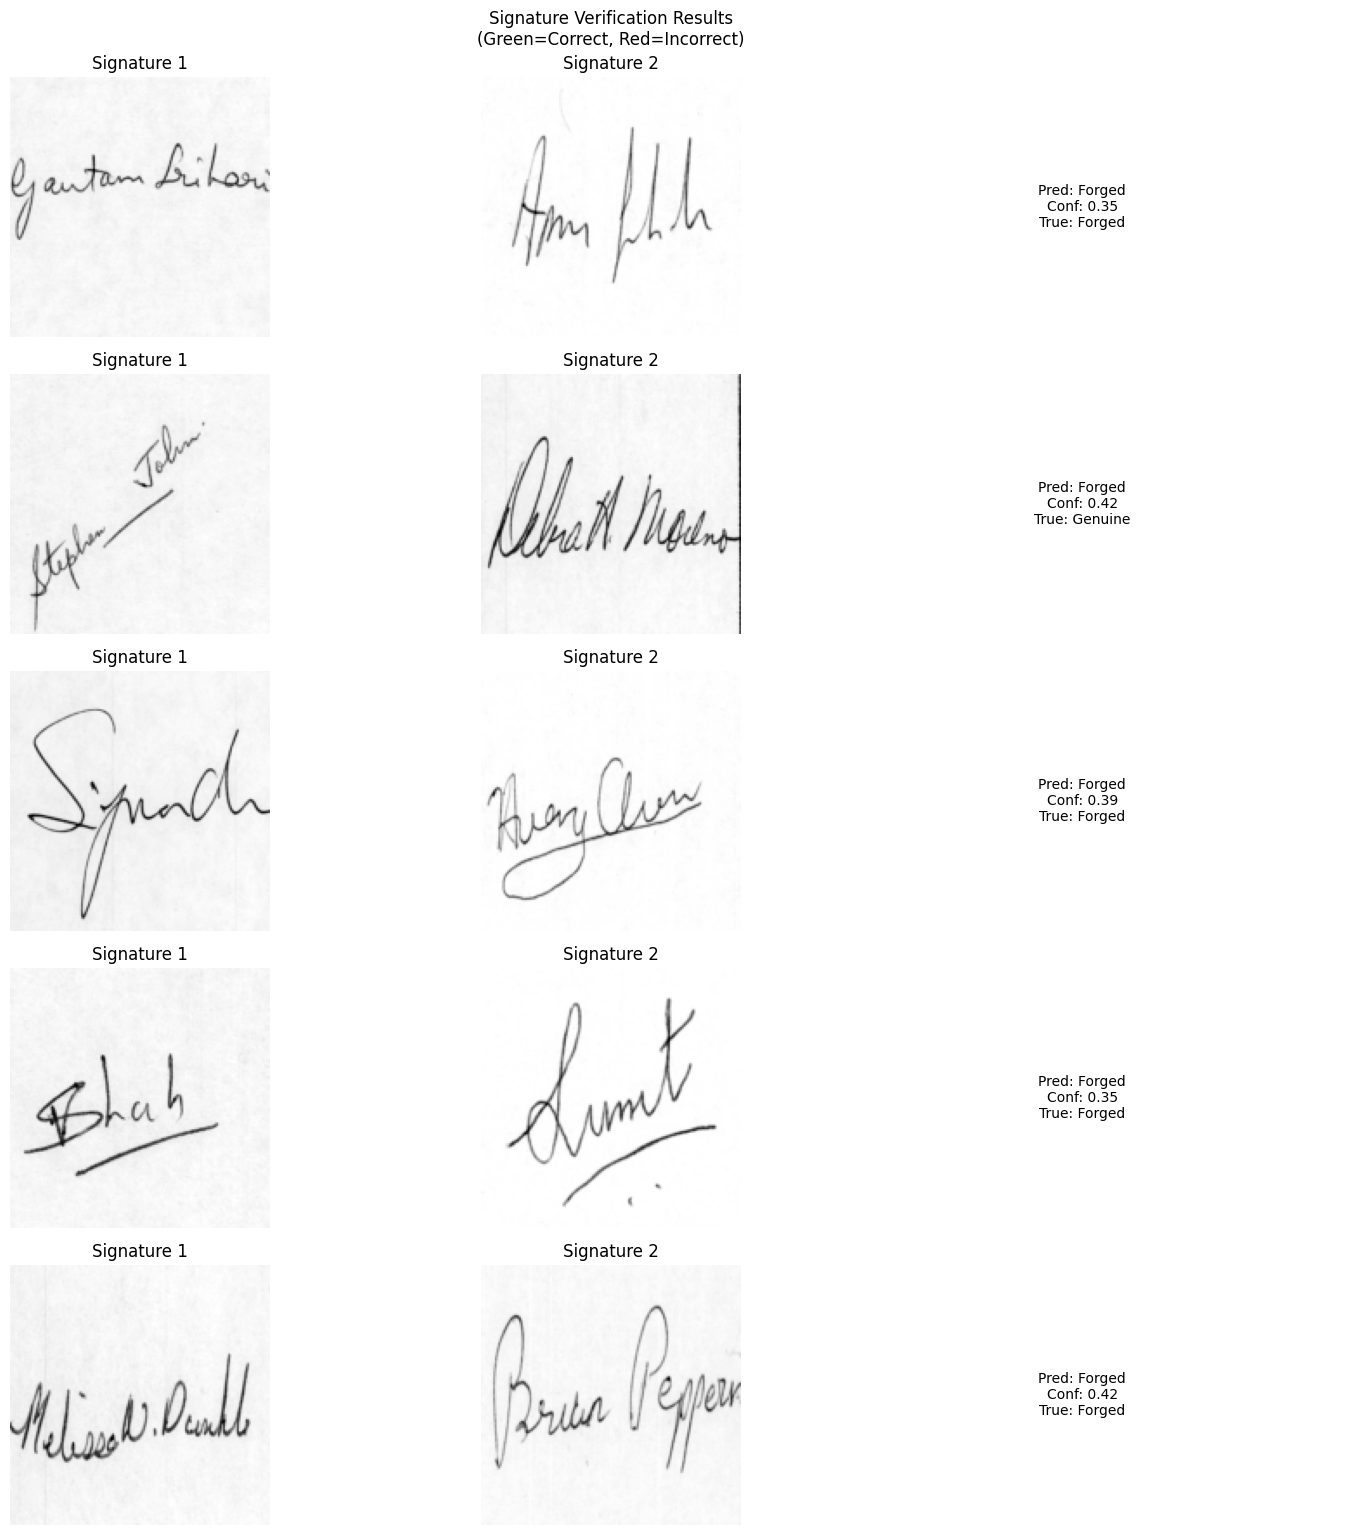

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*3))

    with torch.no_grad():
        # Get one batch
        img1, img2, labels = next(iter(test_loader))
        img1, img2 = img1.to(device), img2.to(device)

        # Get features separately
        feat1 = model.forward_once(img1)  # [batch, 512]
        feat2 = model.forward_once(img2)  # [batch, 512]

        # Manually concatenate features for FC layer (to match network architecture)
        concatenated = torch.cat([feat1, feat2], dim=1)  # [batch, 1024]
        predictions = model.fc(concatenated).squeeze()  # [batch]

        for i in range(num_samples):
            # Display images
            axes[i,0].imshow(img1[i].cpu().squeeze(), cmap='gray')
            axes[i,0].set_title("Signature 1")
            axes[i,0].axis('off')

            axes[i,1].imshow(img2[i].cpu().squeeze(), cmap='gray')
            axes[i,1].set_title("Signature 2")
            axes[i,1].axis('off')

            # Prediction info
            pred = predictions[i].item()
            axes[i,2].text(0.5, 0.5,
                          f"Pred: {'Genuine' if pred > 0.5 else 'Forged'}\n"
                          f"Conf: {pred:.2f}\n"
                          f"True: {'Genuine' if labels[i] == 1 else 'Forged'}",
                          ha='center', va='center', fontsize=10)

            # Color coding
            correct = (pred > 0.5) == (labels[i] == 1)
            axes[i,2].set_facecolor('lightgreen' if correct else 'lightcoral')
            axes[i,2].axis('off')

    plt.tight_layout()
    plt.suptitle("Signature Verification Results\n(Green=Correct, Red=Incorrect)", y=1.02)
    plt.show()

# Visualize predictions
visualize_predictions(model, test_loader, num_samples=5)

[INFO] Best Threshold = 0.4227 (Youden's J = 0.9358)


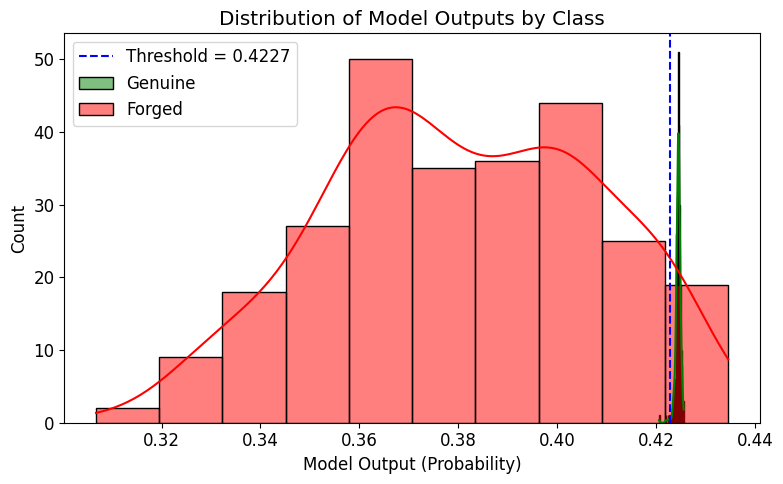

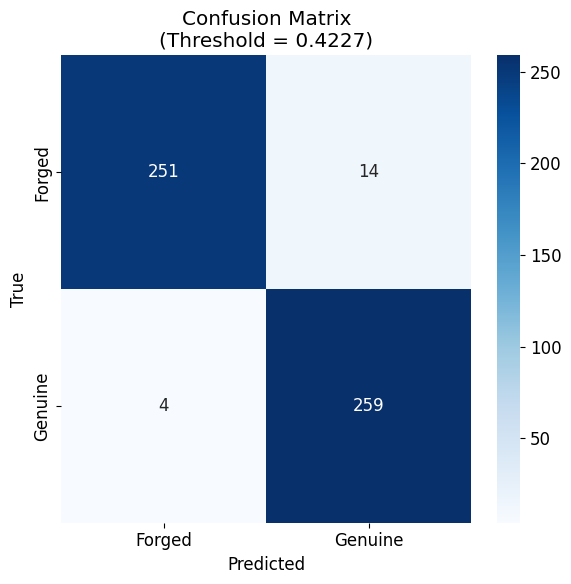

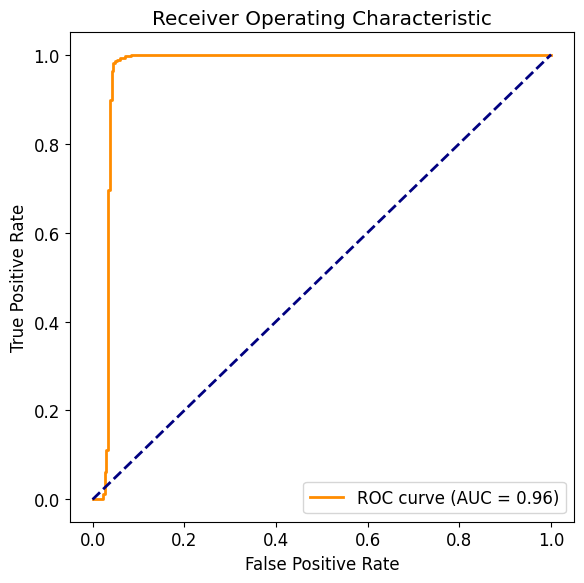

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE

def plot_score_distribution(scores, labels, threshold):
    plt.figure(figsize=(8, 5))
    sns.histplot([s for s, l in zip(scores, labels) if l == 1], color='green', label='Genuine', kde=True)
    sns.histplot([s for s, l in zip(scores, labels) if l == 0], color='red', label='Forged', kde=True)
    plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold = {threshold:.4f}')
    plt.xlabel('Model Output (Probability)')
    plt.ylabel('Count')
    plt.title('Distribution of Model Outputs by Class')
    plt.legend()
    plt.tight_layout()
    plt.show()

def find_best_threshold(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    youdens_j = tpr - fpr
    best_index = youdens_j.argmax()
    best_threshold = thresholds[best_index]
    print(f"[INFO] Best Threshold = {best_threshold:.4f} (Youden's J = {youdens_j[best_index]:.4f})")
    return best_threshold

def generate_paper_visualizations(model, test_loader, device, save_prefix=None):
    """
    Generates publication-ready visualizations:
    1. Score distribution
    2. Confusion matrix
    3. ROC curve
    4. t-SNE visualization
    """
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1, img2 = img1.to(device), img2.to(device)
            feat1 = model.forward_once(img1)
            feat2 = model.forward_once(img2)
            concatenated = torch.cat([feat1, feat2], dim=1)
            probs = model.fc(concatenated).squeeze()
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Step 1: Find best threshold
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    best_thresh = find_best_threshold(all_labels, all_probs)
    all_preds = (all_probs > best_thresh).astype(int)

    # Step 2: Plot score distribution
    plot_score_distribution(all_probs, all_labels, best_thresh)

    # Step 3: Confusion Matrix
    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Forged', 'Genuine'],
                yticklabels=['Forged', 'Genuine'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix\n(Threshold = {best_thresh:.4f})')
    if save_prefix:
        plt.savefig(f"{save_prefix}_confusion.pdf", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    # Step 4: ROC Curve
    plt.figure(figsize=(6, 6))
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    if save_prefix:
        plt.savefig(f"{save_prefix}_roc.pdf", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


generate_paper_visualizations(
    model=model,
    test_loader=test_loader,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    save_prefix="fig"
)



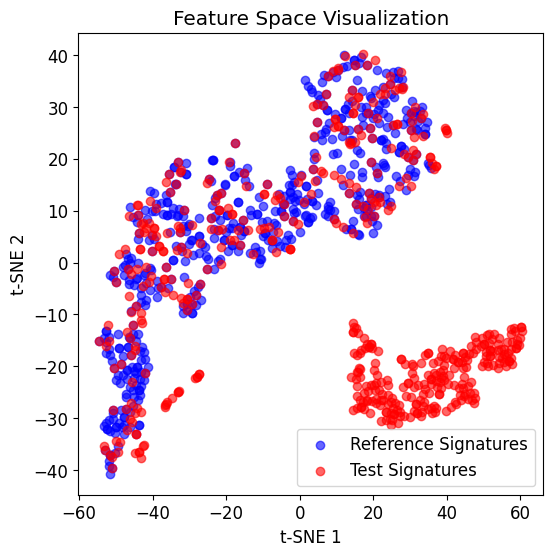

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
import torch
import matplotlib

def generate_paper_visualizations(model, test_loader, num_samples=4, save_prefix=None):
    """
    Generates publication-ready visualizations:
    1. Confusion matrix
    2. ROC curve
    3. t-SNE feature visualization
    """
    matplotlib.rcParams.update({'font.size': 12, 'font.family': 'DejaVu Sans'})
    model.eval()

    all_probs = []
    all_labels = []

    feat1_all = []
    feat2_all = []

    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1, img2 = img1.to(device), img2.to(device)
            feat1 = model.forward_once(img1)
            feat2 = model.forward_once(img2)
            concatenated = torch.cat([feat1, feat2], dim=1)
            probs = model.fc(concatenated).squeeze()

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            feat1_all.append(feat1.cpu())
            feat2_all.append(feat2.cpu())

    # Stack features for t-SNE
    feat1_all = torch.cat(feat1_all, dim=0)
    feat2_all = torch.cat(feat2_all, dim=0)

    # Apply optimal threshold
    optimal_threshold = 0.1508
    all_preds = [1 if p > optimal_threshold else 0 for p in all_probs]  # 1 = Genuine



    # --------------------------------------------------
    # 4. t-SNE Feature Visualization
    # --------------------------------------------------
    plt.figure(figsize=(6, 6))
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(torch.cat([feat1_all, feat2_all], dim=0).numpy())

    plt.scatter(features_tsne[:len(feat1_all), 0], features_tsne[:len(feat1_all), 1],
                c='blue', label='Reference Signatures', alpha=0.6)
    plt.scatter(features_tsne[len(feat1_all):, 0], features_tsne[len(feat1_all):, 1],
                c='red', label='Test Signatures', alpha=0.6)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title('Feature Space Visualization')
    plt.legend()
    if save_prefix:
        plt.savefig(f"{save_prefix}_tsne.pdf", dpi=300, bbox_inches='tight')
    plt.show()

generate_paper_visualizations(
    model=model,
    test_loader=test_loader,
    num_samples=5,  # Number of example pairs to show
    save_prefix="fig"  # Will save as fig_examples.pdf, fig_confusion.pdf, etc.
)

In [ ]:
import pandas as pd

# Confusion matrix values
TP = 251  # True Positives
TN = 259  # True Negatives
FP = 14   # False Positives
FN = 4   # False Negatives

# Metric calculations
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
f1_score = 2 * (precision * recall) / (precision + recall)

# Create a DataFrame for tabular display
metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall (Sensitivity)', 'Specificity', 'F1 Score'],
    'Value': [accuracy, precision, recall, specificity, f1_score],

}

df_metrics = pd.DataFrame(metrics)
print(df_metrics.to_string(index=False))


              Metric    Value
            Accuracy 0.965909
           Precision 0.947170
Recall (Sensitivity) 0.984314
         Specificity 0.948718
            F1 Score 0.965385
